In [1]:
import numpy as np
import torch

from rlaopt.solvers import PCGConfig, SAPConfig, SAPAccelConfig
from rlaopt.preconditioners import NystromConfig

from scalable_gp_inference.hparam_training import train_exact_gp_subsampled, GPHparams
from scalable_gp_inference.gp_inference import GPInference
from scalable_gp_inference.random_features import RFConfig
from scalable_gp_inference.sdd_config import SDDConfig

from experiments.data_processing.load_torch import LOADERS

In [2]:
seed = 0

In [3]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

In [4]:
device = torch.device("cuda:0")

dataset_name = "3droad"
data = LOADERS[dataset_name](split_proportion=0.1, split_shuffle=True, split_seed=seed, standardize=True, dtype=torch.float64, device=device)
Xtr = data.Xtr
ytr = data.ytr
Xtst = data.Xtst
ytst = data.ytst

kernel_type = "matern32"
distributed = False
devices = set([torch.device("cuda:0")])
num_posterior_samples = 64
num_random_features = 2048

# subsample_size = 10000

In [5]:
# hparams = train_exact_gp_subsampled(Xtr=Xtr, ytr=ytr, kernel_type=kernel_type, opt_hparams={"lr": 0.1},
#             training_iters=100, subsample_size=subsample_size, num_trials=1)

hparams = GPHparams(signal_variance=2.7339983636976877, noise_variance=0.00033773878181614375, 
                    kernel_lengthscale=torch.tensor([0.1389760822057724, 0.17519564926624298], device=device))

In [6]:
print(hparams)

GPHparams(signal_variance=2.7339983636976877, kernel_lengthscale=tensor([0.1390, 0.1752], device='cuda:0'), noise_variance=0.00033773878181614375)


In [7]:
gp_inference_model = GPInference(
    Xtr=Xtr,
    ytr=ytr,
    Xtst=Xtst,
    ytst=ytst,
    kernel_type=kernel_type,
    kernel_hparams=hparams,
    num_posterior_samples=num_posterior_samples,
    rf_config=RFConfig(num_features=num_random_features),
    distributed=distributed,
    devices=devices,
)

In [8]:
max_iters = 400
nystrom_config = NystromConfig(rank=100, rho=hparams.noise_variance, damping_mode="adaptive")
accel_config = SAPAccelConfig(mu=hparams.noise_variance, nu=100.0)
solver_config = SAPConfig(
    precond_config=nystrom_config,
    max_iters=max_iters,
    atol=1e-6,
    rtol=1e-6,
    blk_sz=Xtr.shape[0] // 100,
    accel_config=accel_config,
    device=device,
)
# solver_config = SDDConfig(
#     momentum=0.9,
#     step_size=100 / Xtr.shape[0],
#     theta=100 / max_iters,
#     blk_size=Xtr.shape[0] // 10,
#     max_iters=max_iters,
#     device=device,
#     atol=1e-6,
#     rtol=1e-6,
# )
# solver_config = PCGConfig(
#     precond_config=nystrom_config,
#     max_iters=max_iters,
#     atol=1e-6,
#     rtol=1e-6,
#     device=device,
# )

In [9]:
results = gp_inference_model.perform_inference(
    solver_config=solver_config,
    W_init=None,
    use_full_kernel=False,
    eval_freq=20,
    log_in_wandb=True,
    wandb_init_kwargs={"project": "3droad_testing"}
)

wandb: Currently logged in as: pratikrathore8 (sketchy-opts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((1+d*Sqrt(Sum(((a-b)/c)**2)))*f)*Exp(e*Sqrt(Sum(((a-b)/c)**2))) with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,2,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,1,1) ... OK
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((1+d*Sqrt(Sum(((a-b)/c)**2)))*Exp(e*Sqrt(Sum(((a-b)/c)**2))))*f with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,2,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,64,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((1+d*Sqrt(Sum(((a-b)/c)**2)))*Exp(e*Sqrt(Sum(((a-b)/c)**2))))*f with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,2,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,100,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((1+d*Sqrt(Sum(((a-b)/c)**2)))*Exp(e*Sqrt(Sum

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


cum_time,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
iter_time,▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
cum_time,576.5541
iter_time,28.67982


In [31]:
log = results["log"]
log.keys()

dict_keys([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400])

In [32]:
final_log_entry = log[list(log.keys())[-1]]
final_log_entry_metrics = final_log_entry["metrics"]

In [33]:
final_log_entry_metrics

{'callback': {'test_rmse': 0.2879279955977251,
  'test_r2': 0.9181227460742468,
  'test_mean': array([-0.93356195,  0.4621644 ,  1.41721034, ..., -0.14092515,
         -0.5972797 , -0.42445433], shape=(43488,)),
  'test_posterior_samples_mean': array([-0.93826256,  0.46075197,  1.39081214, ..., -0.1449596 ,
         -0.59778503, -0.43068106], shape=(43488,)),
  'test_posterior_samples_var': array([0.00458287, 0.01316037, 0.01544131, ..., 0.01035151, 0.00560031,
         0.02367199], shape=(43488,)),
  'test_posterior_samples_nll': 171629.02709444085,
  'test_posterior_samples_mean_nll': 3.9465835884483274},
 'internal_metrics': {'abs_res': None, 'rel_res': None}}

(array([3.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 1.000e+01,
        1.200e+01, 1.500e+01, 2.000e+01, 4.500e+01, 5.700e+01, 4.400e+01,
        8.200e+01, 1.180e+02, 1.840e+02, 2.750e+02, 4.160e+02, 4.720e+02,
        6.390e+02, 9.410e+02, 1.212e+03, 1.690e+03, 2.135e+03, 2.947e+03,
        3.619e+03, 4.133e+03, 4.388e+03, 4.210e+03, 3.712e+03, 3.032e+03,
        2.340e+03, 1.815e+03, 1.335e+03, 9.490e+02, 7.180e+02, 5.200e+02,
        3.670e+02, 2.800e+02, 2.150e+02, 1.480e+02, 1.240e+02, 7.600e+01,
        6.300e+01, 3.900e+01, 2.000e+01, 1.200e+01, 1.100e+01, 1.000e+01,
        4.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 8.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

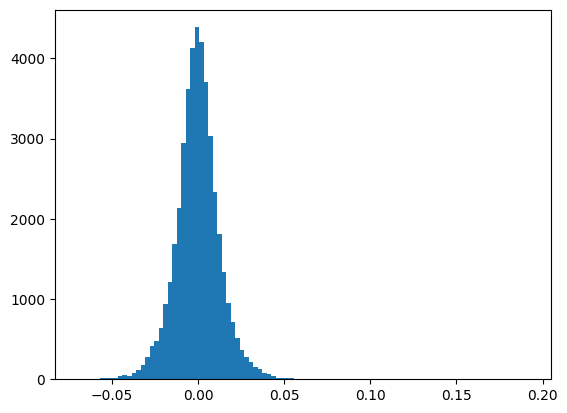

In [34]:
import matplotlib.pyplot as plt
plt.hist(final_log_entry_metrics["callback"]["test_mean"] -
         final_log_entry_metrics["callback"]["test_posterior_samples_mean"], bins=100)


(array([1.5172e+04, 1.1235e+04, 7.9330e+03, 4.7960e+03, 2.2870e+03,
        1.0400e+03, 4.3200e+02, 2.4400e+02, 1.3000e+02, 7.1000e+01,
        4.8000e+01, 2.9000e+01, 1.7000e+01, 1.1000e+01, 9.0000e+00,
        6.0000e+00, 3.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

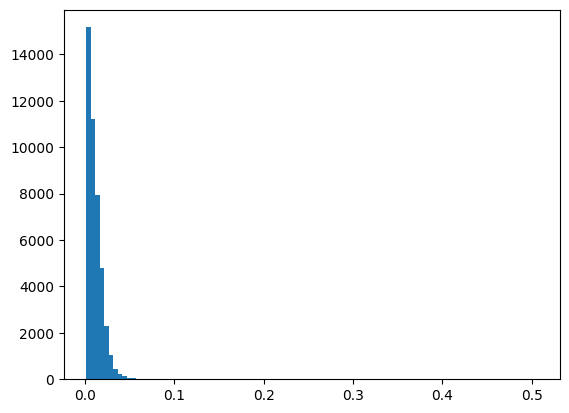

In [35]:
plt.hist(final_log_entry_metrics["callback"]["test_posterior_samples_var"], bins=100)

In [36]:
# Extract information for computing log likelihood
test_mean = final_log_entry_metrics["callback"]["test_mean"]
test_variances = final_log_entry_metrics["callback"]["test_posterior_samples_var"]
y_test = gp_inference_model.ytst.cpu().numpy()
y_train = gp_inference_model.ytr.cpu().numpy()

# Compute log likelihood for each test point
test_variances = test_variances + gp_inference_model.noise_variance
# n = test_mean.shape[0]
log_test_variances = np.log(test_variances)

# Get individual log likelihoods
log_likelihoods = -0.5 * np.log(2 * np.pi) - 0.5 * log_test_variances - 0.5 * (y_test - test_mean) ** 2 / test_variances

In [37]:
# Get index of the 5 smallest log likelihoods
sorted_indices = np.argsort(log_likelihoods)
smallest_indices = sorted_indices[:5]
smallest_log_likelihoods = log_likelihoods[smallest_indices]
print("Indices of the 5 smallest log likelihoods:", smallest_indices)
print("Smallest log likelihoods:", smallest_log_likelihoods)


# Get the corresponding test mean and variance along with the true value
smallest_test_means = test_mean[smallest_indices]
smallest_test_variances = test_variances[smallest_indices]
smallest_true_values = y_test[smallest_indices]
print("Smallest test means:", smallest_test_means)
print("Smallest test variances:", smallest_test_variances)
print("True values:", smallest_true_values)

Indices of the 5 smallest log likelihoods: [ 6331  2594 10510 39862 13423]
Smallest log likelihoods: [-476.75743708 -419.08446726 -386.28867332 -366.4704551  -343.78880538]
Smallest test means: [3.93675655 1.50685525 1.21792084 1.53149832 1.39635302]
Smallest test variances: [0.00459447 0.00330538 0.00320846 0.00362018 0.00322725]
True values: [6.03370235 3.17516846 2.79630854 3.16461627 2.89019616]


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00,
        2.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00, 1.0000e+00,
        7.0000e+00, 3.0000e+00, 7.0000e+00, 4.0000e+00, 6.0000e+00,
        6.0000e+00, 5.0000e+00, 8.0000e+00, 6.00

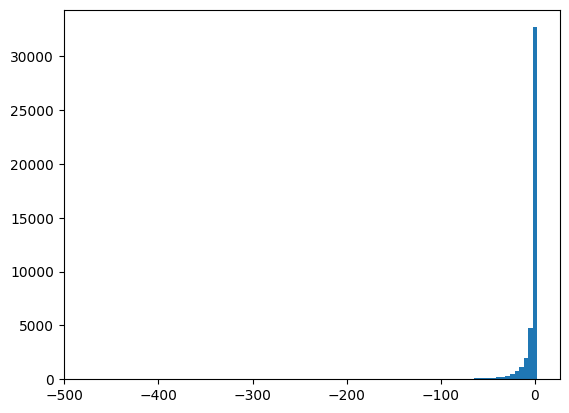

In [38]:
plt.hist(log_likelihoods, bins=100)

(array([1.000e+00, 0.000e+00, 1.600e+01, 9.490e+02, 3.074e+03, 2.451e+03,
        2.174e+03, 2.073e+03, 1.623e+03, 1.599e+03, 1.440e+03, 1.573e+03,
        1.425e+03, 1.302e+03, 1.212e+03, 1.291e+03, 1.231e+03, 1.089e+03,
        1.099e+03, 1.075e+03, 1.036e+03, 1.040e+03, 1.083e+03, 1.024e+03,
        8.510e+02, 8.400e+02, 7.650e+02, 7.080e+02, 6.390e+02, 6.160e+02,
        5.470e+02, 5.120e+02, 5.210e+02, 4.630e+02, 4.350e+02, 4.320e+02,
        4.140e+02, 3.930e+02, 3.830e+02, 3.160e+02, 3.120e+02, 3.050e+02,
        2.610e+02, 2.360e+02, 1.830e+02, 2.090e+02, 1.970e+02, 1.680e+02,
        1.890e+02, 1.510e+02, 1.580e+02, 1.460e+02, 1.250e+02, 1.240e+02,
        1.220e+02, 9.000e+01, 1.130e+02, 5.700e+01, 7.300e+01, 5.100e+01,
        5.100e+01, 5.200e+01, 6.100e+01, 4.100e+01, 4.200e+01, 3.600e+01,
        3.700e+01, 3.200e+01, 2.800e+01, 2.300e+01, 1.900e+01, 1.400e+01,
        1.000e+01, 7.000e+00, 1.200e+01, 1.000e+00, 9.000e+00, 6.000e+00,
        4.000e+00, 3.000e+00, 4.000e+0

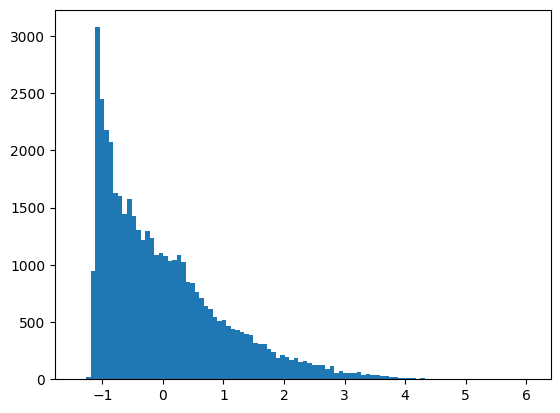

In [39]:
plt.hist(y_test, bins=100)

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 8.0000e+00,
        9.0000e+01, 5.0360e+03, 2.6460e+04, 2.2867e+04, 2.0833e+04,
        1.9708e+04, 1.5002e+04, 1.3971e+04, 1.3181e+04, 1.3821e+04,
        1.3119e+04, 1.2006e+04, 1.1539e+04, 1.1304e+04, 1.1141e+04,
        1.0264e+04, 1.0259e+04, 9.6890e+03, 9.4180e+03, 9.8650e+03,
        9.9170e+03, 9.0760e+03, 8.0670e+03, 7.9030e+03, 7.1980e+03,
        6.5880e+03, 5.8330e+03, 5.5160e+03, 5.0540e+03, 4.7820e+03,
        4.2720e+03, 4.1320e+03, 4.0640e+03, 3.8780e+03, 3.6110e+03,
        3.2380e+03, 3.1860e+03, 2.9570e+03, 2.7640e+03, 2.4280e+03,
        2.1950e+03, 2.0420e+03, 1.8510e+03, 1.8090e+03, 1.5470e+03,
        1.6230e+03, 1.4790e+03, 1.3840e+03, 1.2790e+03, 1.1480e+03,
        1.0490e+03, 9.8800e+02, 1.0810e+03, 1.0200e+03, 8.5800e+02,
        7.4500e+02, 6.5700e+02, 5.3500e+02, 5.0100e+02, 4.6100e+02,
        4.1400e+02, 3.5600e+02, 2.8500e+02, 2.8000e+02, 2.1400e+02,
        2.2800e+02, 2.0600e+02, 1.7900e+02, 1.46

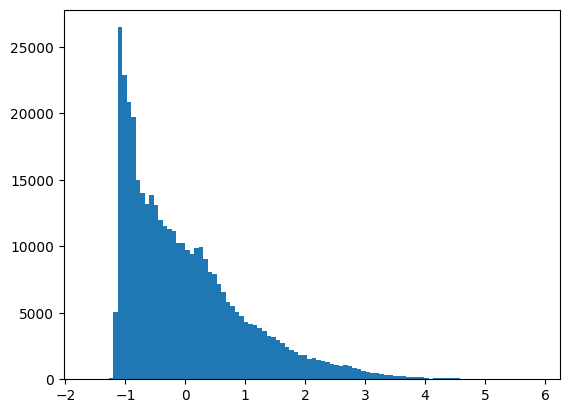

In [40]:
plt.hist(y_train, bins=100)